In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

# BLACK WITH FATHER

In [4]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
merged_controls = False
    
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [6]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [7]:
def load_subject(subject, data_directory, threshold1, threshold2, merged_controls=False):
    file_suffix = 'cells' + str(threshold1) if subject[0] == 'B' else 'cells' + str(threshold2)
    if merged_controls:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    else:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [8]:
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject, 
                                                                                                data_directory=data_directory, 
                                                                                                threshold1=2000, 
                                                                                                threshold2=300, 
                                                                                                merged_controls=True), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_mergedcontrols.npy', dict_results_across_mice)
# np.save('dict_results/dict_results_across_mice_BL_woF2000_mergedcontrols.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_mergedcontrols.npy', 
                                   allow_pickle=True).item()

In [11]:
subjects = list(dict_results_across_mice.keys())

In [12]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


## Calculate number of cells

In [14]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [15]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.0105524,0.104755,0.119017
1,Primary motor area,0.088829,0.508445,0.0719831
2,Secondary motor area,0.0223361,0.903714,0.0669885
3,Primary somatosensory area,0.0678488,0.779152,0.102647
4,Supplemental somatosensory area,0.105283,0.929036,0.225283
...,...,...,...,...
194,Interfascicular nucleus raphe,0.281215,0.584837,0.237149
195,Interpeduncular nucleus,0.636087,0.945032,0.503844
196,Rostral linear nucleus raphe,0.393468,0.705065,0.619625
197,Central linear nucleus raphe,0.178464,0.343826,0.477001


In [16]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [17]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Medial amygdalar nucleus,3.11867e-05
Accessory olfactory bulb,0.000445391
Cortical amygdalar area,0.000535849
Periventricular hypothalamic nucleus posterior part,0.00135988
Ventral premammillary nucleus,0.00228878
Posterior amygdalar nucleus,0.0039752
Main olfactory bulb,0.00631505
Frontal pole cerebral cortex,0.0105524
Bed nuclei of the stria terminalis,0.010595


In [18]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:40].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,1.80999e-07
Cortical amygdalar area,9.7229e-07
Posterior amygdalar nucleus,1.64107e-06
Ventral premammillary nucleus,3.61996e-06
Bed nuclei of the stria terminalis,8.39763e-05
Periventricular hypothalamic nucleus posterior part,8.51502e-05
Piriform-amygdalar area,0.000104503
Accessory olfactory bulb,0.000241203
Main olfactory bulb,0.000685116


In [19]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Posterior amygdalar nucleus,0.00648058
Bed nuclei of the stria terminalis,0.00820067
Nucleus of the brachium of the inferior colliculus,0.0110284
Septohippocampal nucleus,0.0181034
Piriform-amygdalar area,0.0255912
Mediodorsal nucleus of thalamus,0.037009
Intercalated amygdalar nucleus,0.039848
Nucleus accumbens,0.0565348
Basolateral amygdalar nucleus,0.0583594


## Calculate corr matrices on number of cells

In [20]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

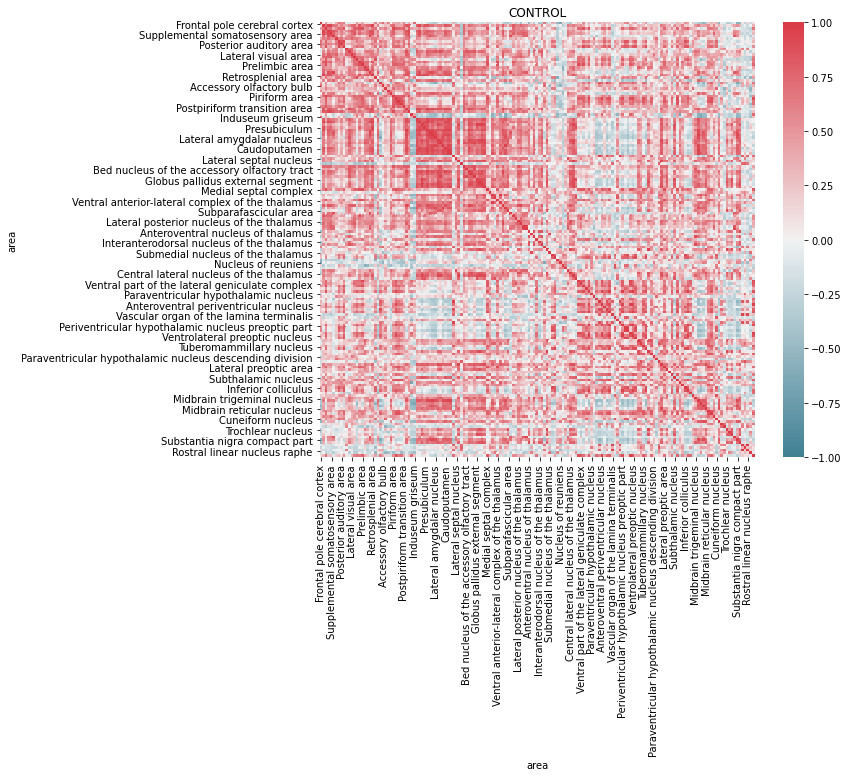

In [21]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

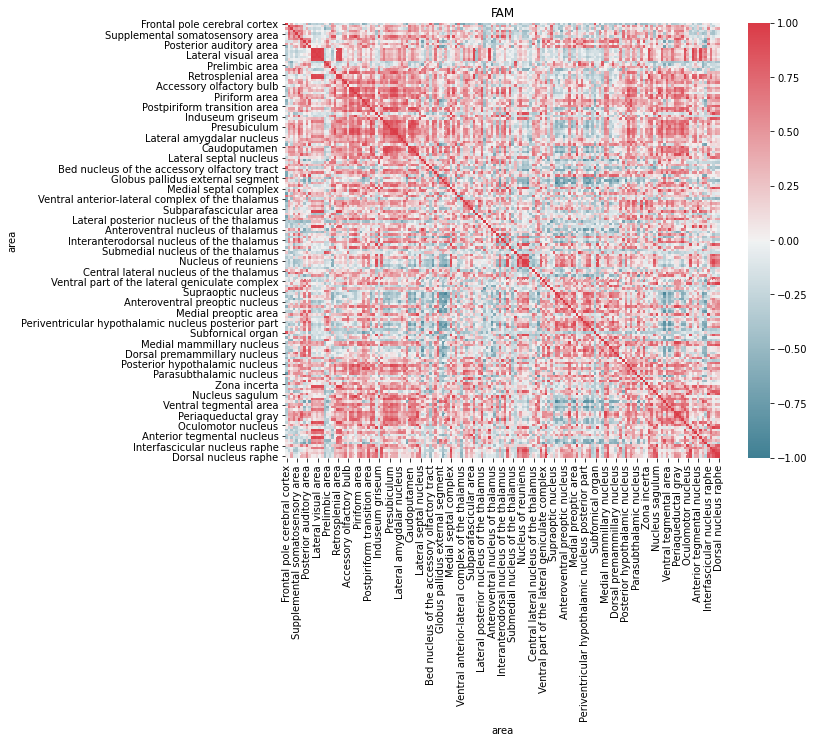

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

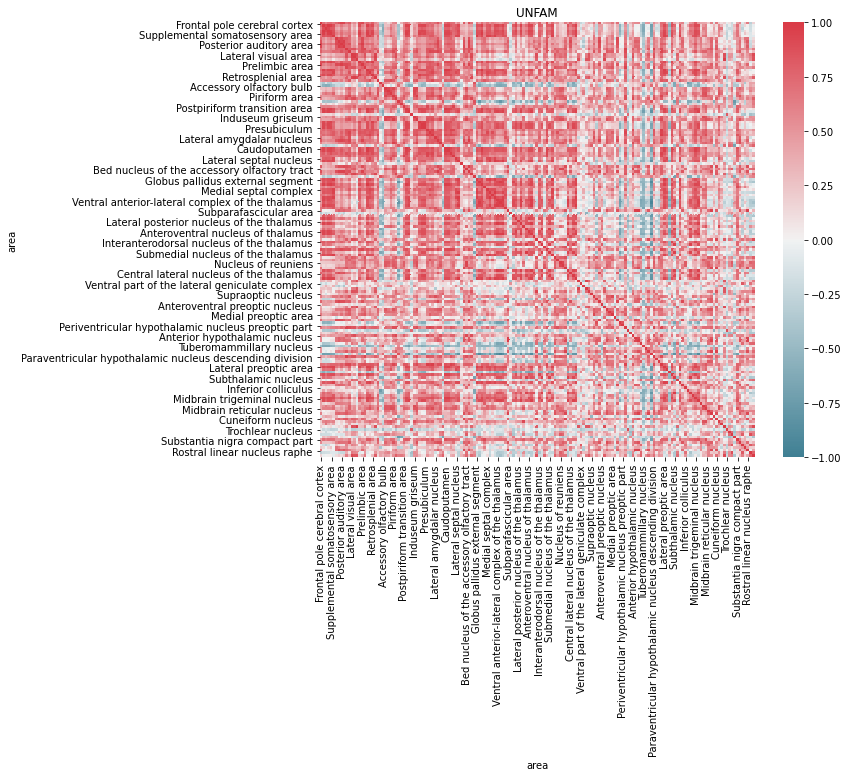

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

## Calculate energy across experimental groups

In [24]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [25]:
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])


In [26]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [27]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Medial amygdalar nucleus,7.06005e-05
Cortical amygdalar area,0.000135125
Accessory olfactory bulb,0.000645548
Medial preoptic nucleus,0.00165837
Main olfactory bulb,0.00173056
Periventricular hypothalamic nucleus posterior part,0.0018802
Piriform-amygdalar area,0.00493067
Ventral premammillary nucleus,0.00518706
Medial preoptic area,0.00771771


In [28]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Medial amygdalar nucleus,5.89623e-07
Cortical amygdalar area,6.79834e-07
Piriform-amygdalar area,8.94519e-06
Ventral premammillary nucleus,1.61035e-05
Posterior amygdalar nucleus,6.49435e-05
Bed nuclei of the stria terminalis,7.16838e-05
Main olfactory bulb,0.000160445
Medial preoptic nucleus,0.000204316
Periventricular hypothalamic nucleus posterior part,0.000235035


In [29]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nuclei of the stria terminalis,0.00441499
Septohippocampal nucleus,0.0123706
Posterior amygdalar nucleus,0.0133285
Nucleus of the brachium of the inferior colliculus,0.0218416
Mediodorsal nucleus of thalamus,0.0315238
Nucleus accumbens,0.0474961
Piriform area,0.0494192
Intercalated amygdalar nucleus,0.0516193
Perirhinal area,0.060043


In [30]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

Text(0.5, 1.0, 'CONTROL')

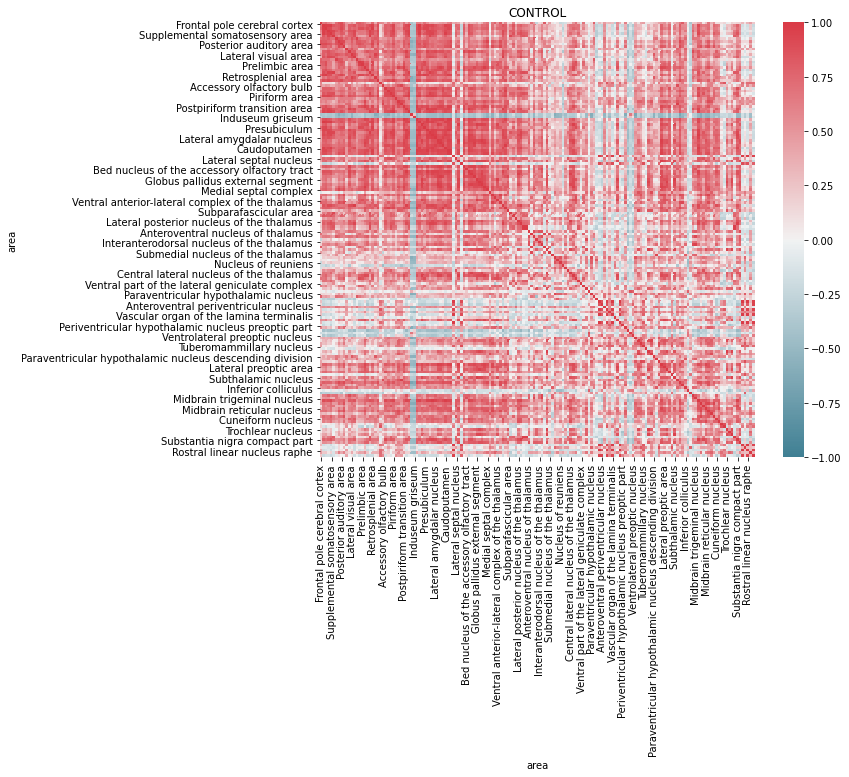

In [31]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

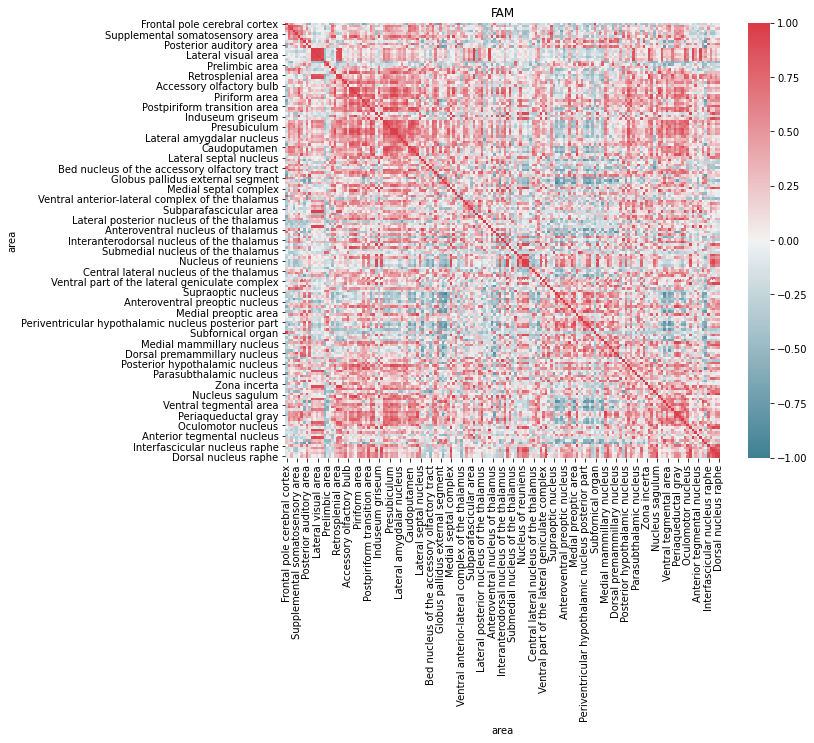

In [32]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

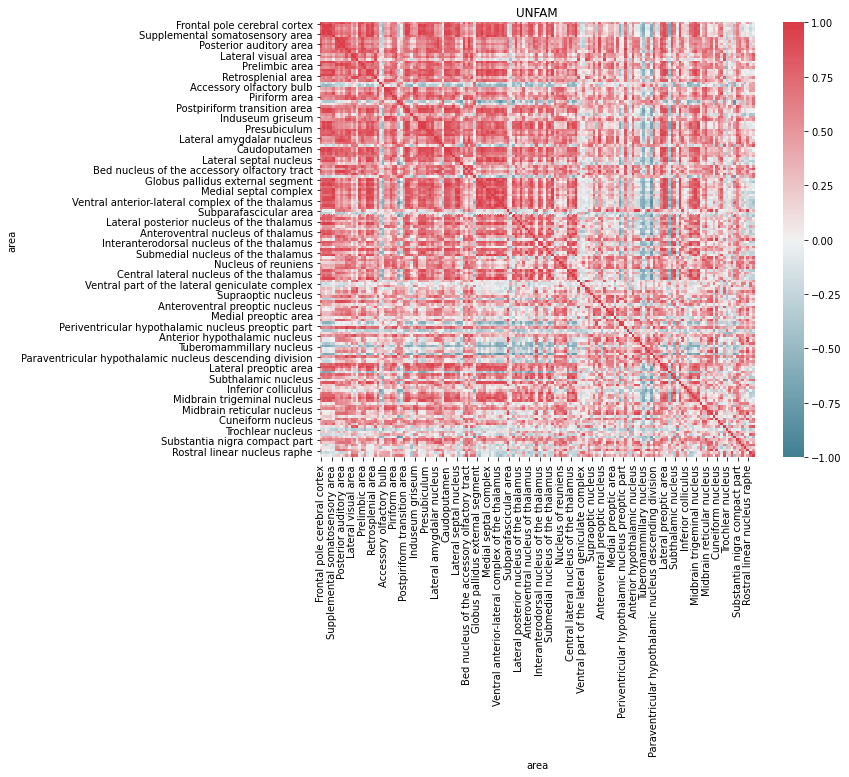

In [33]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')